In [1]:
import json
import os
import math
from tqdm import tqdm

def load_game(filename: str) -> dict:
    """Load game data from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


games = []
game_path = os.path.join(".", "crawler", "games", "classic")

for file in tqdm(os.listdir(game_path)):
    if file.endswith(".json"):
        game_data = load_game(os.path.join(game_path, file))
        games.append(game_data)

print(f"Loaded {len(games)} games.")

players = []
players_name_lvl = {}
for game in tqdm(games):
    for participant in game.get("info").get("participants", []):
        players_name_lvl[participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")] = participant.get("summonerLevel", 0)

for name, level in players_name_lvl.items():
    players.append((name, level))

print(f"Unique players: {len(players)}")



100%|██████████| 35153/35153 [02:11<00:00, 268.27it/s]


Loaded 35153 games.


100%|██████████| 35153/35153 [00:01<00:00, 22895.54it/s]


Unique players: 253672


In [2]:
from analysis.core import *

In [3]:
len(get_all_participants(games))

100%|██████████| 35153/35153 [00:00<00:00, 39285.02it/s]


252934 total number of players.


252934

In [4]:
print(get_all_gametypes(games))

  0%|          | 0/35153 [00:00<?, ?it/s]

100%|██████████| 35153/35153 [00:00<00:00, 352849.43it/s]

['MATCHED_GAME', 'CUSTOM_GAME']


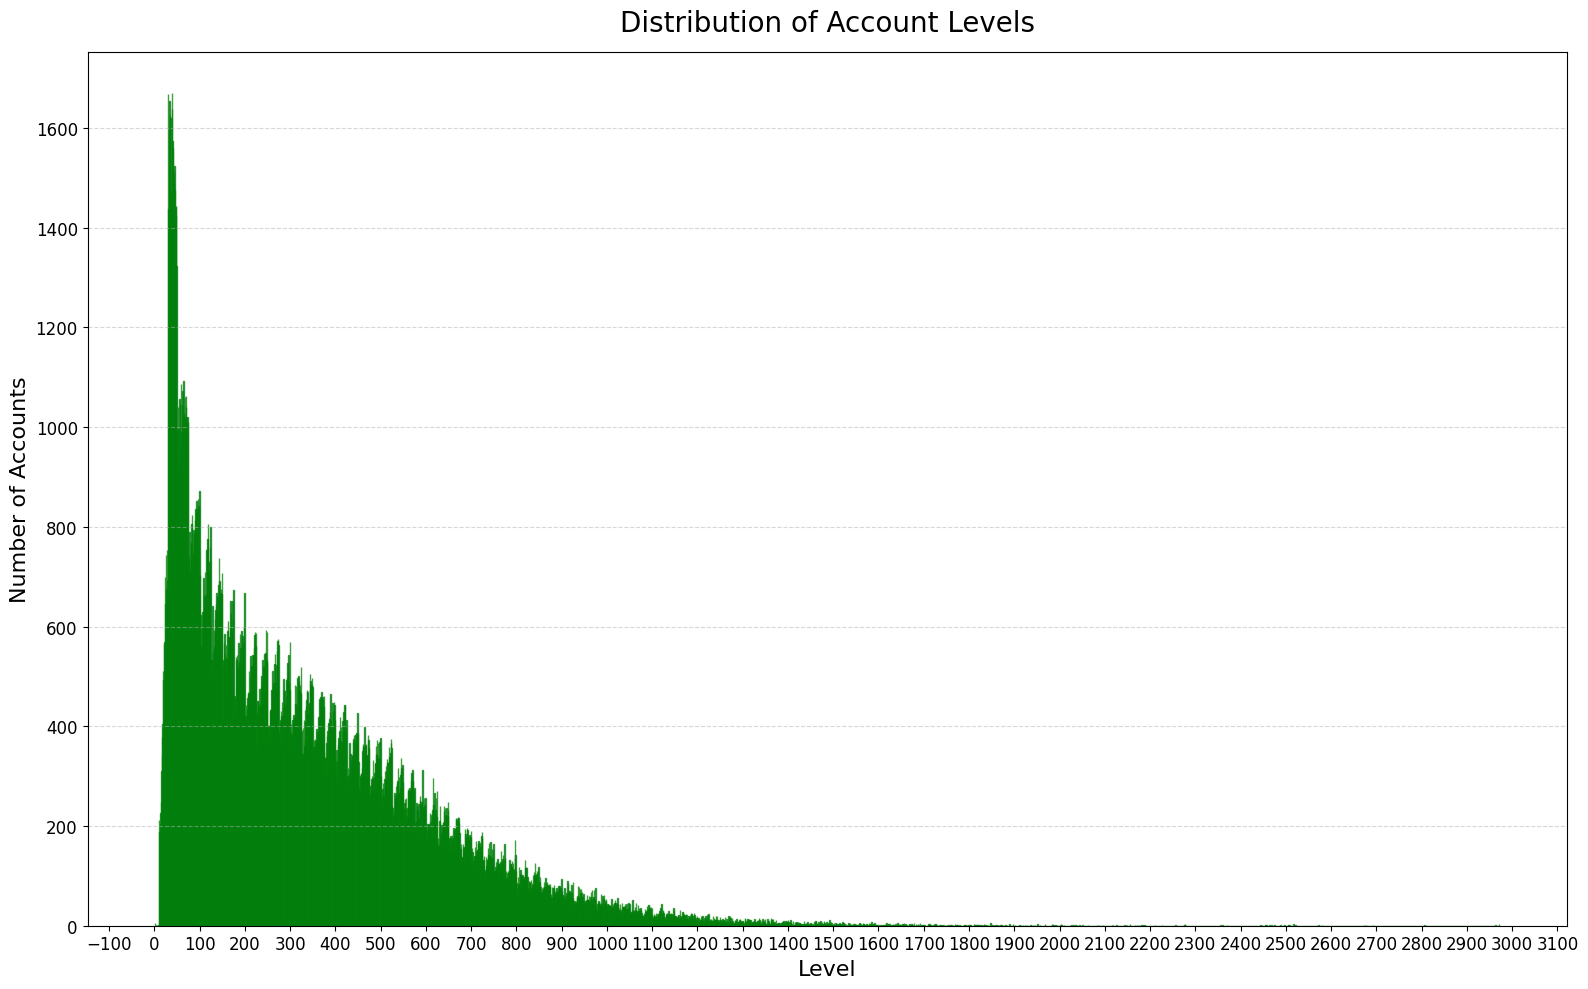

"Qnoxs #17165" Level: 2971


In [5]:
plot_level_distribution(games)
hname, hlevel = get_highest_level_player(games)
print(f"\"{hname}\" Level: {hlevel}")

100%|██████████| 61/61 [00:39<00:00,  1.54it/s]


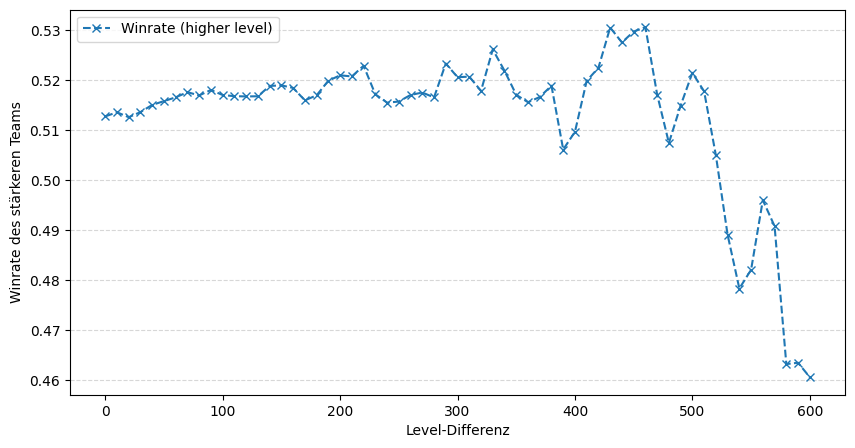

In [6]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 61)]
winrates = [higher_level_winrate(games, d) for d in tqdm(diffs)]

plt.figure(figsize=(10, 5))
plt.plot(diffs, winrates, marker="x", linestyle="--", label="Winrate (higher level)")

#plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
#plt.yticks([i/10 for i in range(0, 11)])

plt.xlabel("Level-Differenz")
plt.ylabel("Winrate des stärkeren Teams")
plt.legend()
plt.show()


100%|██████████| 101/101 [01:04<00:00,  1.58it/s]


[0.5074911701036801, 0.5075928255844574, 0.5082834721428786, 0.5084761463640575, 0.5087970020325203, 0.5090308225901446, 0.5091914864910446, 0.5094516644659115, 0.5087542692791659, 0.5087562744004461, 0.5094419283027558, 0.5097906819716408, 0.5091513460275772, 0.5099180223420975, 0.5105728227898184, 0.5109675070537908, 0.5112643461011666, 0.5114271701814616, 0.5118594138859262, 0.513370958383881, 0.5139961654341276, 0.5144011839708561, 0.5147146078082354, 0.5153461372197863, 0.5153791819174212, 0.5157043571237637, 0.5169935096657129, 0.516461952176757, 0.5144933020510104, 0.515695067264574, 0.5154520862365768, 0.5155658754729963, 0.5157724454030737, 0.5162106446776612, 0.5172515193099392, 0.5203935232629637, 0.5199486576104396, 0.5203716140586523, 0.5216730926510106, 0.5225577698985207, 0.5217391304347826, 0.522, 0.5217209690893901, 0.5211555296177415, 0.5225885225885226, 0.5206757843925985, 0.5220836142953472, 0.5214007782101168, 0.5201267238166232, 0.52076802507837, 0.518411253620190

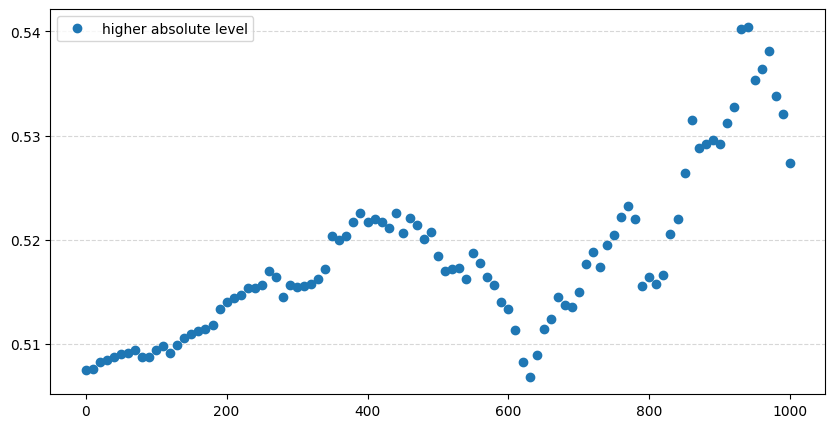

In [7]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 101)]
winrates_higher = [higher_absolute_level_winrate(games, d) for d in tqdm(diffs)]

print(winrates_higher)
plt.figure(figsize=(10, 5))

plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/100 for i in range(0, 101)])
plt.plot(diffs, winrates_higher, marker="o", linestyle="", label="higher absolute level")
plt.legend()
plt.show()

(21828.2, 18631.0)
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000]
33733 Wins with higher champion level and 1382 Wins with lower champion level of 35115 games
33114 Wins with higher champion level and 1145 Wins with lower champion level of 34259 games
32780 Wins with higher champion level and 1012 Wins with lower champion level of 33792 games
32504 Wins with higher champion level and 914 Wins with lower champion level of 33418 games
32232 Wins with higher champion level and 835 Wins with lower champion level of 33067 games
31937 Wins with higher champion level and 759 Wins with lower champion level of 32696 games
31614 Wins with higher champion level and 678 Wins with lower champion 

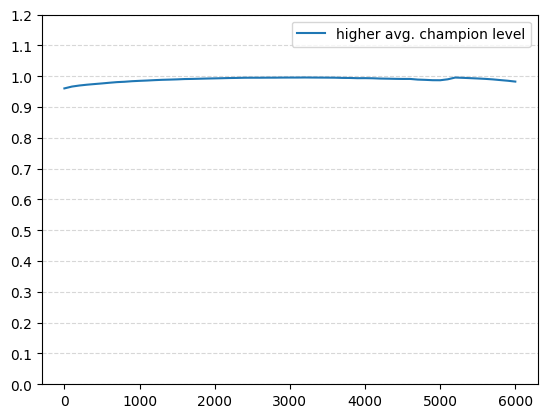

In [8]:
import matplotlib.pyplot as plt
print(get_team_champion_levels(games[1]))
diffs = [i * 100 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_champion_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 13)])
plt.plot(diffs, winrates_higher, label="higher avg. champion level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

In [9]:
print(get_percentage_of_surrendered_games(games))

0.2877421557192843


 31%|███▏      | 11026/35153 [00:00<00:00, 110222.79it/s]

100%|██████████| 35153/35153 [00:00<00:00, 116126.16it/s]


0.36244870866521844


100%|██████████| 35153/35153 [00:00<00:00, 131572.72it/s]


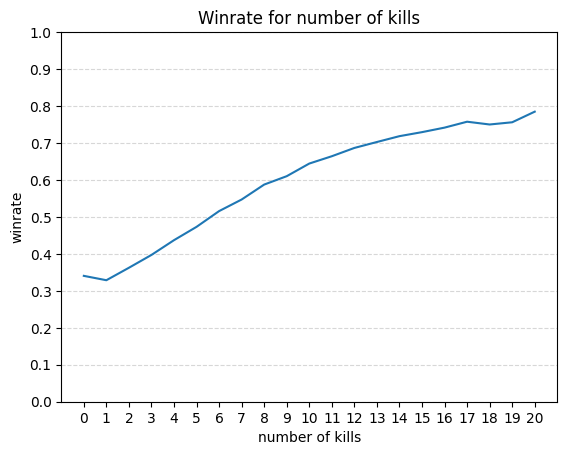

In [10]:
print(get_winratio_for_nr_kills(games, 2))
kills = [i for i in range(0, 21)]
winratio = [get_winratio_for_nr_kills(games, k) for k in kills]
plt.yticks([i/10 for i in range(0, 13)])
plt.xticks(kills)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.title("Winrate for number of kills")
plt.xlabel("number of kills")
plt.ylabel("winrate")
plt.plot(kills, winratio)
plt.show()

100%|██████████| 35153/35153 [00:00<00:00, 124921.31it/s]


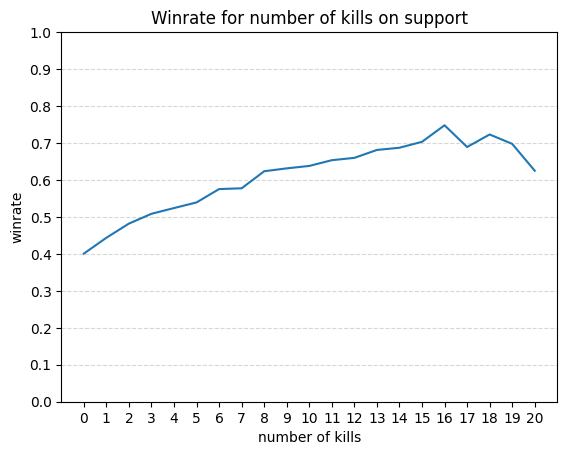

In [11]:
kills = [i for i in range(0, 21)]
winratio = [get_winratio_for_nr_kills_and_role(games, k, "SUPPORT", "BOTTOM") for k in kills]
plt.yticks([i/10 for i in range(0, 13)])
plt.xticks(kills)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.title("Winrate for number of kills on support")
plt.xlabel("number of kills")
plt.ylabel("winrate")
plt.plot(kills, winratio)
plt.show()

100%|██████████| 35153/35153 [00:00<00:00, 131535.52it/s]


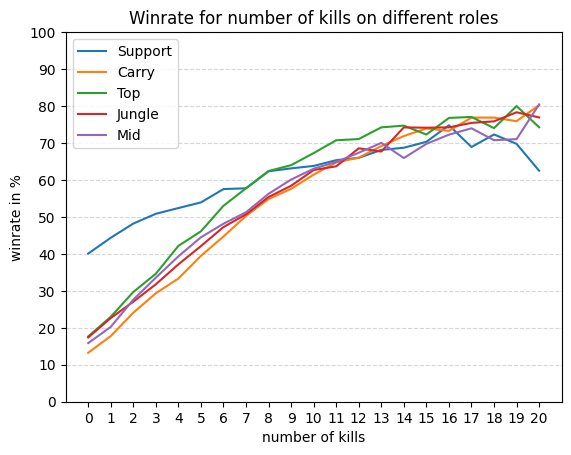

In [12]:
plt.yticks([i*10 for i in range(0, 13)])
plt.xticks(kills)
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.title("Winrate for number of kills on different roles")
plt.xlabel("number of kills")
plt.ylabel("winrate in %")

kills = [i for i in range(0, 21)]
winratio = [get_winratio_for_nr_kills_and_role(games, k, "SUPPORT", "BOTTOM") * 100 for k in kills]
plt.plot(kills, winratio, label="Support")

winratio = [get_winratio_for_nr_kills_and_role(games, k, "CARRY", "BOTTOM") * 100 for k in kills]
plt.plot(kills, winratio, label="Carry")

winratio = [get_winratio_for_nr_kills_and_role(games, k, "SOLO", "TOP") * 100 for k in kills]
plt.plot(kills, winratio, label="Top")

winratio = [get_winratio_for_nr_kills_and_role(games, k, "NONE", "JUNGLE") * 100 for k in kills]
plt.plot(kills, winratio, label="Jungle")

winratio = [get_winratio_for_nr_kills_and_role(games, k, "SOLO", "MIDDLE") * 100 for k in kills]
plt.plot(kills, winratio, label="Mid")
plt.legend()
plt.show()